In [1]:
import os
import gc
import time
import json
import copy

import pickle
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
from PIL import Image

import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## a. Utils Functions

In [2]:
def getImage_opencv(img_path, resized_width = 1024, color_space="rgb"):
    img = cv2.imread(img_path)
    if color_space == "rgb":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width = img.shape[:2]
    resized_height = resized_width * height/width
    img = cv2.resize(img, (int(resized_width), int(resized_height)))
    return img

def getImage_pillow(img_path, resized_width = 1024):
    img = Image.open(img_path)
    img = img.convert("RGB")
    
    width, height = img.size
    resized_height = resized_width * height/width
    img = img.resize((int(resized_width), int(resized_height)))
    return img

def opencv_to_pillow(img):
    img = Image.fromarray(img)
    return img

# 用于展示图片和masks
def simple_show(img, size = (4,3)):
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.show()

def show_masks(used_img, masks, borders = True, show_img = True, show_mask = True, size=(8,6)):
    np.random.seed(3)
    plt.figure(figsize=size)
    if show_img:
        plt.imshow(used_img)

    if show_mask:
        if len(masks) == 0:
            return

        ax = plt.gca()
        # 打开或关闭图形的自动缩放功能。
        # 当自动缩放功能开启时，图形会根据数据自动调整坐标轴的范围，以确保所有数据点都能够适应在图形中显示。
        ax.set_autoscale_on(False) 

        height, width = used_img.shape[:2]
        
        img = np.ones((height, width, 4))
        img[:,:,3] = 0

        for r in masks:
            m = r["segmentation"]
            color_mask = np.concatenate([np.random.random(3), [0.5]])
            img[m] = color_mask
            if borders:
                contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
                cv2.drawContours(img, contours, -1, (1, 0, 0, 0.5), thickness=2)
        ax.imshow(img)

def show_def_masks(
    used_img, sorted_masks, mask = None, maskIDs = None, 
    drawBbox=True, 
    isDownload=False, downloadPath = "./results/testImgs/test.jpg",
    tags=None, tagIDs = None):

    img_opencv = cv2.cvtColor(used_img, cv2.COLOR_RGB2BGR)
    
    np.random.seed(3)
    alpha = 0.4
    
    # 这个函数可以接受两种不同的masks：(1) 直接输入一个mask (2) 输入一串masksID
    masks_list = []
    if mask is not None:
        masks_list.append(mask)
    elif maskIDs is not None:
        masks_list = [sorted_masks[i]["segmentation"] for i in maskIDs]

    overlay = np.zeros_like(img_opencv)
    filter_img = np.zeros_like(img_opencv)

    for i, m in enumerate(masks_list):
        mask_rgb = np.zeros_like(img_opencv)
        mask_rgb[m] = np.random.randint(0,256,size=3) # 生成一个rgb颜色
        overlay += mask_rgb # 获取颜色块
        filter_img[m] = img_opencv[m]


    output = cv2.addWeighted(filter_img, 1-alpha, overlay, alpha, 0)

    if isDownload:
        cv2.imwrite(downloadPath, output)

    # 下面是展示图片的部分
    plt.figure(figsize=(8,6))
    if maskIDs is not None and drawBbox:
        for i, idx in enumerate(maskIDs):
            x, y, w, h = sorted_masks[idx]["bbox"]
            rect = patches.Rectangle((x,y),w,h,linewidth = 1, edgecolor = "r", facecolor="none")
            ax = plt.gca()
            ax.add_patch(rect)
            ax.text(x+w,y+h,str(idx),ha="right",va="bottom",color="white",fontsize=7)

            if tagIDs is not None:
                if idx in tagIDs:
                    t = tags[i]
                    bbox_props = dict(boxstyle="square,pad=0.3", facecolor="black", edgecolor="black")
                    ax.text(x,y,t,ha="left",va="top",color="lime",bbox = bbox_props,fontsize=6,fontweight='bold')

    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    show_output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    plt.imshow(show_output)
    plt.show()

# 用于输出masks
def getMaskImage(img_opencv, masks, sortedMaskID, maskTag=True):
    img = cv2.cvtColor(img_opencv, cv2.COLOR_RGB2BGR)
    
    m = masks[sortedMaskID]
    x = int(masks[sortedMaskID]["bbox"][0])
    y = int(masks[sortedMaskID]["bbox"][1])
    w = int(masks[sortedMaskID]["bbox"][2])
    h = int(masks[sortedMaskID]["bbox"][3])

    img_m = np.zeros_like(img)
    color_mask = np.array([255,255,255], dtype=np.uint8)
    img_m[m["segmentation"]] = color_mask # 制作掩码
    masked_image = cv2.bitwise_and(img, img_m) # 通过掩码获取图片彩色的部分
    
    if maskTag:
        processed_roi = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
        roi_image = processed_roi[y:y+h,x:x+w]
        roi_image[np.where((roi_image == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
        return roi_image
    else:
        roi_image = img[y:y+h,x:x+w] # 如果需要masked之后的图片，可以使用processed_roi[y:y+h,x:x+w]
        roi_image = cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB)
        roi_image[np.where((roi_image == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
        return roi_image

# 常见的坐标转换函数
def xyxy_to_xywh(bbox):
    x_min = bbox[0]
    y_min = bbox[1]
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    return [x_min, y_min, w, h]

def xyxyn_to_xywh(bbox, width, height):
    x_min = int(bbox[0] * width)
    y_min = int(bbox[1] * height)
    w = int((bbox[2] - bbox[0]) * width)
    h = int((bbox[3] - bbox[1]) * height)
    return [x_min, y_min, w, h]

def get_bbox_xyxy(bbox):
    x_min = int(bbox[0])
    y_min = int(bbox[1])
    x_max = int(bbox[0] + bbox[2])
    y_max = int(bbox[1] + bbox[3])
    return [x_min, y_min, x_max, y_max]

def get_bbox_xywh(bbox):
    x_min = int(bbox[0])
    y_min = int(bbox[1])
    w = int(bbox[2] - bbox[0])
    h = int(bbox[3] - bbox[1])
    return [x_min, y_min, w, h]

def get_box_mask(bbox,segmentation):
    bbox_xyxy = get_bbox_xyxy(bbox)
    box_mask = np.zeros_like(segmentation,dtype=bool)# 注：segmentation的mask的形状是(h,w)
    box_mask[bbox_xyxy[1]:bbox_xyxy[3]+1,bbox_xyxy[0]:bbox_xyxy[2]+1] = True
    return box_mask

def is_surrounded(outer_bbox,inner_bbox): # 好像没啥用，hhhh
    outer_bbox = get_bbox_xyxy(outer_bbox)
    inner_bbox = get_bbox_xyxy(inner_bbox)
    return (
        outer_bbox[0] <= inner_bbox[0] and
        outer_bbox[1] <= inner_bbox[1] and
        outer_bbox[2] >= inner_bbox[2] and
        outer_bbox[3] >= inner_bbox[3]
    )

def get_segMask_ratio(sorted_masks, id1, id2):
    seg_mask_1 = sorted_masks[id1]["segmentation"] # 小
    seg_mask_2 = sorted_masks[id2]["segmentation"] # 大

    seg_its = seg_mask_1 & seg_mask_2
    seg_area_1 = np.sum(seg_mask_1)
    seg_area_its = np.sum(seg_its)
    seg_ratio = seg_area_its / seg_area_1
    return seg_ratio

def get_boxMask_ratio(sorted_masks, id1, id2):
    box_mask_1 = get_box_mask(sorted_masks[id1]["bbox"], sorted_masks[id1]["segmentation"]) #小
    box_mask_2 = get_box_mask(sorted_masks[id2]["bbox"], sorted_masks[id2]["segmentation"]) #大

    box_its = box_mask_1 & box_mask_2
    box_area_1 = np.sum(box_mask_1)
    box_area_its = np.sum(box_its)
    box_ratio = box_area_its / box_area_1
    return box_ratio

## b.分割模型的定义

In [11]:
# SAM
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
# SAM2
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
# FastSAM
from ultralytics.models.fastsam import FastSAMPredictor

In [12]:
def sam_model(img_opencv, device, sam_name = "vit_h"):
    # 只测试：vit_h (其他的模型效果一般)
    np.random.seed(3)
    sam_model_list = {
        "vit_h":"./weights/sam_models/sam/sam_vit_h_4b8939.pth",
        "vit_l":"./weights/sam_models/sam/sam_vit_l_0b3195.pth",
        "vit_b":"./weights/sam_models/sam/sam_vit_b_01ec64.pth",
    }

    sam = sam_model_registry[sam_name](checkpoint=sam_model_list[sam_name])
    sam.to(device = device)

    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=64,
        pred_iou_thresh= 0.915,#0.92, 
        stability_score_thresh=0.65, # 能够更大程度地对整个画面进行分割(约束更加松弛了)
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=100.0
    )

    starttime = time.time()
    masks = mask_generator.generate(img_opencv)
    endtime = time.time()

    sorted_masks = sorted(masks,key=(lambda x:x["area"]), reverse=True)

    del sam
    del mask_generator
    del masks
    torch.cuda.empty_cache()
    gc.collect()
    
    return {"run_time":endtime - starttime, "sorted_masks":sorted_masks, "img_opencv":img_opencv}

In [10]:
from PIL import Image
import os
import math
import matplotlib.pyplot as plt

In [4]:
img_id = 1
img_path = f"./selected images/{img_id}.jpg"
target_path = f"./scaled_images/" + str(img_id)

In [7]:
if not os.path.exists(target_path):
    os.mkdir(target_path)

In [9]:
org_img = Image.open(img_path)
org_width, org_height = org_img.size

In [11]:
math.sqrt(2)

1.4142135623730951

In [10]:
source_img_root = "./selected images/"
target_img_root = "./scaled_images/"

In [11]:
def imgScale(img_id, scale_factor = 2, showTag = True, saveTag = True):
    global source_img_root, target_img_root
    org_img_path = source_img_root + str(img_id) + ".jpg"

    target_img_folder = target_img_root + str(img_id)
    if not os.path.exists(target_img_folder):
        os.mkdir(target_img_folder)

    target_img_path = target_img_root+ f"/{img_id}/" + str(img_id) + "_" + str(scale_factor) + ".jpg"

    img = Image.open(org_img_path)
    org_width, org_height = img.size

    reduced_width = int(org_width/math.sqrt(scale_factor))
    reduced_height = int(org_height/math.sqrt(scale_factor))

    reduced_img = img.resize((reduced_width, reduced_height), Image.LANCZOS)

    restored_img = reduced_img.resize((org_width, org_height), Image.LANCZOS)

    if showTag:
        plt.figure(figsize=(8,6))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Origin Image")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(restored_img)
        plt.title("Blured Image")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    if saveTag:
        restored_img.save(target_img_path)

In [8]:
img_list = [1,23,35,44,49,57,68,81,92,96]
scale_factors = [4,16,32]

In [13]:
for img_f in img_list:
    for sf in scale_factors:
        imgScale(img_f, scale_factor = sf, showTag = False, saveTag = True)

In [9]:
sam_funcs = {
    "sam":sam_model,
}
sam_models = {
    "sam":"vit_h",
}
time_log = {
    "sam":{},
}

NameError: name 'sam_model' is not defined

In [17]:
img_list

[1, 23, 35, 44, 49, 57, 68, 81, 92, 96]

In [18]:
for k, v in sam_funcs.items():
    print(f"{k} model Running:")
    for img_f in img_list:
        for sf in scale_factors:
            img_path = f"./scaled_images/{img_f}/{img_f}_{sf}.jpg"

            mask_path = f"./scaled_images/results/mask_folder/masked_region_{img_f}_{sf}/"
            if not os.path.exists(mask_path):
                os.makedirs(mask_path)
            pkl_path = f"./scaled_images/results/pkl_info/{img_f}_{sf}.pkl"

            img_pillow = getImage_pillow(img_path = img_path, resized_width = 1024)
            img_opencv = getImage_opencv(img_path = img_path, resized_width = 1024, color_space="rgb")
            if k == "sam":
                results = v(img_opencv=img_opencv, device=device, sam_name = sam_models[k])

            run_time = results['run_time']
            sorted_masks = results['sorted_masks']
            used_img = results['img_opencv']
            print(f"----> Image: {img_f}_{sf}  Running time: {run_time}s")

            
            time_log[k][img_f] = run_time
            with open(pkl_path, "wb") as fp:
                pickle.dump(results, fp)
    
            for i in range(len(sorted_masks)):
                if sorted_masks[i]["area"] < 20:
                    continue
                subregion = getMaskImage(used_img, masks=sorted_masks, sortedMaskID=i, maskTag= True)
                subimage_pillow = opencv_to_pillow(subregion)
                subimage_pillow.save(mask_path+f"{i}_t.jpg")
            time.sleep(2)
        print("-------------------------------------------------------")

sam model Running:
----> Image: 1_4  Running time: 21.043095588684082s
----> Image: 1_16  Running time: 19.961249351501465s
----> Image: 1_32  Running time: 19.9730544090271s
-------------------------------------------------------
----> Image: 23_4  Running time: 19.25883436203003s
----> Image: 23_16  Running time: 19.86638379096985s
----> Image: 23_32  Running time: 19.703428506851196s
-------------------------------------------------------
----> Image: 35_4  Running time: 19.87349033355713s
----> Image: 35_16  Running time: 20.09325885772705s
----> Image: 35_32  Running time: 19.836753129959106s
-------------------------------------------------------
----> Image: 44_4  Running time: 23.150691986083984s
----> Image: 44_16  Running time: 22.49149513244629s
----> Image: 44_32  Running time: 21.81028962135315s
-------------------------------------------------------
----> Image: 49_4  Running time: 25.03586173057556s
----> Image: 49_16  Running time: 25.563144207000732s
----> Image: 49_32

## 3. 构造includeTree和Filter Strategy

In [19]:
def get_includeTree_t2(sorted_masks):
    total_len = len(sorted_masks)

    includeTree = {
        i:{"direct_parent":None, "indirect_parent":None,"children_seg":[],"children_box":[]} 
        for i in range(total_len)
    }
    starttime = time.time()
    for k_1 in tqdm(range(total_len-1,-1,-1)):
        for k_2 in range(k_1-1,-1,-1): 
            seg_ratio = get_segMask_ratio(sorted_masks, k_1, k_2)
    
            # direct parent
            if seg_ratio > 0.475: # 两者像素重叠 # 一开始是0.2
                if includeTree[k_1]["direct_parent"] == None and includeTree[k_1]["indirect_parent"] == None:
                    includeTree[k_1]["direct_parent"] = k_2
                    includeTree[k_2]["children_seg"].append(k_1)
                elif includeTree[k_1]["direct_parent"] == None and includeTree[k_1]["indirect_parent"] != None:
                    indir_parent = includeTree[k_1]["indirect_parent"]
                    includeTree[k_1]["direct_parent"] = k_2
                    includeTree[k_1]["indirect_parent"] = None
                    includeTree[k_2]["children_seg"].append(k_1)
                    includeTree[indir_parent]["children_box"].remove(k_1)
                elif includeTree[k_1]["direct_parent"] != None:
                    dir_parent = includeTree[k_1]["direct_parent"]
                    c_seg_ratio = get_segMask_ratio(sorted_masks, k_1, dir_parent)
                    mul_seg_ratio = get_segMask_ratio(sorted_masks, dir_parent, k_2)
    
                    if mul_seg_ratio >0.5:
                        includeTree[k_1]["direct_parent"] = k_2
                        includeTree[k_2]["children_seg"].append(k_1)
                        includeTree[dir_parent]["children_seg"].remove(k_1)
                    elif mul_seg_ratio<=0.5 and seg_ratio > c_seg_ratio:
                        includeTree[k_1]["direct_parent"] = k_2
                        includeTree[k_2]["children_seg"].append(k_1)
                        includeTree[dir_parent]["children_seg"].remove(k_1)
    
            elif seg_ratio <= 0.475: # 两者像素不重叠；因此，判断bbox的重叠情况 # 一开始是0.2
                box_ratio = get_boxMask_ratio(sorted_masks,k_1,k_2)
                
                # indirect parent
                if box_ratio >= 0.5: # 说明k_1在k_2内，只是像素不重叠
                    if includeTree[k_1]["direct_parent"] == None and includeTree[k_1]["indirect_parent"] == None:
                        includeTree[k_1]["indirect_parent"] = k_2
                        includeTree[k_2]["children_box"].append(k_1)
                    elif includeTree[k_1]["direct_parent"] == None and includeTree[k_1]["indirect_parent"] != None:
                        indir_parent = includeTree[k_1]["indirect_parent"]
                        c_box_ratio = get_boxMask_ratio(sorted_masks,k_1,indir_parent)
    
                        mul_seg_ratio = get_segMask_ratio(sorted_masks,indir_parent,k_2)
                        if mul_seg_ratio > 0.5:
                            includeTree[k_1]["indirect_parent"] = k_2
                            includeTree[k_2]["children_box"].append(k_1)
                            includeTree[indir_parent]["children_box"].remove(k_1)
                        
                        elif mul_seg_ratio <= 0.5 and box_ratio > c_box_ratio:
                            includeTree[k_1]["indirect_parent"] = k_2
                            includeTree[k_2]["children_box"].append(k_1)
                            includeTree[indir_parent]["children_box"].remove(k_1)
                            
                    elif includeTree[k_1]["direct_parent"] != None:
                        continue
                    
                elif box_ratio < 0.5: # 说明k_1和k_2是互相分离的，两者不存在关系
                    continue
                    
        if includeTree[k_1]["direct_parent"] != None and includeTree[k_1]["indirect_parent"] != None:
            indirect_parent = includeTree[k_1]["indirect_parent"]
            includeTree[indirect_parent]["children_box"].remove(k_1)
            includeTree[k_1]["indirect_parent"] = None
    
    endtime = time.time()
    return {"includeTree":includeTree, "run_time":endtime-starttime}

In [20]:
def filter_includeTree_t2(includeTree, feature_area = 2048):
    ancestorNodes = {k:v for k,v in includeTree.items() if v["direct_parent"] == None and v["indirect_parent"]==None}
    
    ancestor_keep_set = []
    ancestor_filter_set = []
    
    starttime = time.time()
    for k,v in ancestorNodes.items():
        area = sorted_masks[k]["area"]
        w = sorted_masks[k]["bbox"][2]
        h = sorted_masks[k]["bbox"][3]
        if area > feature_area and w*h > feature_area:
            ancestor_keep_set.append(k)
        else:
            ancestor_filter_set.append(k)

    # 在ancestor_keep_set中，filter掉很小的object
    updated_tree = {
        i:{
            "children_seg":{"keep":None, "filter":None},
            "children_box":{"keep":None, "filter":None},
            "children_seg_box":[]
        } for i in ancestor_keep_set
    }

    # 对于ancestor_keep_set中的children_seg。在filter掉很小的object之后，需要获取他们的children_box
    for anc in ancestor_keep_set:
        children_seg = includeTree[anc]["children_seg"]
        # 第一步：filter掉children_seg中比较小的部分
        keep_seg = []
        filter_seg = []
        children_seg_box_list = []
        keep_seg_box = []
        
        for n in children_seg:
            area = sorted_masks[n]["area"]
            w = sorted_masks[n]["bbox"][2]
            h = sorted_masks[n]["bbox"][3]
            if area > feature_area or h*w > feature_area:
                keep_seg.append(n)
            else:
                filter_seg.append(n)
            
            # 第二步：将children_seg中的children_box提取出来
            children_seg_box_list.extend(includeTree[n]["children_box"])
            
        children_seg_box_list = list(set(children_seg_box_list))
        for cb in children_seg_box_list:
            area = sorted_masks[cb]["area"]
            w = sorted_masks[cb]["bbox"][2]
            h = sorted_masks[cb]["bbox"][3]
            if area > feature_area or h*w > feature_area:
                keep_seg_box.append(cb)
        
        updated_tree[anc]["children_seg"]["keep"] = keep_seg
        updated_tree[anc]["children_seg"]["filter"] = filter_seg 
        updated_tree[anc]["children_seg_box"].extend(keep_seg_box)

    # for anc in ancestor_keep_set:
    #     children_box = includeTree[anc]["children_box"]
    #     # 第一步：filter掉children_seg中比较小的部分
    #     keep_box = []
    #     filter_box = []
    #     children_box_box_list = []
    #     keep_box_box = []
        
    #     for n in children_box:
    #         area = sorted_masks[n]["area"]
    #         w = sorted_masks[n]["bbox"][2]
    #         h = sorted_masks[n]["bbox"][3]
    #         if h*w > feature_area and area > feature_area:
    #             keep_box.append(n)
    #         else:
    #             filter_box.append(n)


    for anc in ancestor_keep_set:
        pretain_list = []
        oper_list = [anc]
        while len(oper_list) != 0:
            tag_num = oper_list.pop()
            children_box = includeTree[tag_num]["children_box"]
            oper_list.extend(children_box)
            pretain_list.extend(children_box)
    
        keep_box = []
        filter_box = []
        for n in pretain_list:
            area = sorted_masks[n]["area"]
            w = sorted_masks[n]["bbox"][2]
            h = sorted_masks[n]["bbox"][3]
            if h*w > feature_area and area > feature_area:
                keep_box.append(n)
            else:
                filter_box.append(n)
            
        updated_tree[anc]["children_box"]["keep"] = keep_box
        updated_tree[anc]["children_box"]["filter"] = filter_box

    ancestors_node = []
    children_box_node = []
    for k, v in updated_tree.items():
        ancestors_node.append(k)
        childbox = v["children_box"]["keep"]
        childsegbox = v["children_seg_box"]
        children_box_node.extend(childbox)
        children_box_node.extend(childsegbox)
    
    children_box_node = list(set(children_box_node))
    endtime = time.time()
    return {
        "updated_tree":updated_tree,
        "ancestors_node":ancestors_node,
        "children_box_node":children_box_node,
        "run_time":endtime-starttime
    }

In [21]:
for img_f in img_list:
    for sf in scale_factors:
        print(f"----> Image:{img_f}_{sf}")
        pkl_root = f"./scaled_images/results/pkl_info/{img_f}_{sf}.pkl"
        with open(pkl_root, "rb") as fp:
            results = pickle.load(fp)

        sorted_masks = results['sorted_masks']
        used_img = results['img_opencv']

        results = get_includeTree_t2(sorted_masks)

        includeTree_root = f"./scaled_images/results/includeTree_info/{img_f}_{sf}.pkl"
        with open(includeTree_root, "wb") as fp:
            pickle.dump(results, fp)
        print("  --> IncludeTree Written Successfully")

        includeTree = results["includeTree"]
        includeTree_runtime = results["run_time"]

        results = filter_includeTree_t2(includeTree, feature_area = 1500)

        keepNode_root = f"./scaled_images/results/keep_node_info/{img_f}_{sf}.pkl"
        with open(keepNode_root, "wb") as fp:
            pickle.dump(results, fp)
        print("  --> KeepNodes Written Successfully")

        updated_tree = results["updated_tree"]
        ancestors_node = results["ancestors_node"]
        children_box_node = results["children_box_node"]
        filter_runtime = results["run_time"]
        time.sleep(3)

----> Image:1_4


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:41<00:00,  5.54it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:1_16


100%|████████████████████████████████████████████████████████████████████████████████| 208/208 [00:33<00:00,  6.19it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:1_32


100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [00:30<00:00,  6.54it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:23_4


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:37<00:00,  5.64it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:23_16


100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [00:39<00:00,  5.48it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:23_32


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:37<00:00,  5.65it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:35_4


100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [00:48<00:00,  5.10it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:35_16


100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:33<00:00,  6.26it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:35_32


100%|████████████████████████████████████████████████████████████████████████████████| 206/206 [00:32<00:00,  6.41it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:44_4


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:28<00:00,  6.46it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:44_16


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:29<00:00,  6.33it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:44_32


100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [00:25<00:00,  6.80it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:49_4


100%|████████████████████████████████████████████████████████████████████████████████| 193/193 [00:31<00:00,  6.13it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:49_16


100%|████████████████████████████████████████████████████████████████████████████████| 181/181 [00:27<00:00,  6.51it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:49_32


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:19<00:00,  7.70it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:57_4


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.34it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:57_16


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:24<00:00,  7.28it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:57_32


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:18<00:00,  8.35it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:68_4


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:37<00:00,  6.28it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:68_16


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:43<00:00,  5.82it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:68_32


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:38<00:00,  6.24it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:81_4


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:40<00:00,  5.76it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:81_16


100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:36<00:00,  6.05it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:81_32


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:29<00:00,  6.72it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:92_4


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:10<00:00,  4.16it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:92_16


100%|████████████████████████████████████████████████████████████████████████████████| 273/273 [01:00<00:00,  4.51it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:92_32


100%|████████████████████████████████████████████████████████████████████████████████| 241/241 [00:47<00:00,  5.10it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:96_4


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:49<00:00,  5.04it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:96_16


100%|████████████████████████████████████████████████████████████████████████████████| 241/241 [00:46<00:00,  5.14it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Image:96_32


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:37<00:00,  5.77it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully


## 4. CLIP model定义

In [3]:
import clip
import open_clip
# from open_clip import tokenizer
from transformers import AutoProcessor, AutoModel, CLIPImageProcessor,CLIPTokenizer

In [4]:
def clip_model(img_pillow, texts, keywords, device, clip_name = "ViT-L-14"):
    # 需要测试 ViT-L-14, RN50x64
    clip_model_list = {
        "RN50x64":"./weights/clip_models/clip/RN50x64.pt",
        "ViT-B-16":"./weights/clip_models/clip/ViT-B-16.pt",
        "ViT-B-32":"./weights/clip_models/clip/ViT-B-32.pt",
        "ViT-L-14":"./weights/clip_models/clip/ViT-L-14.pt"
    }
    model, preprocess = clip.load(name = clip_model_list[clip_name],device=device)
    model.eval()
    
    # 对文本进行预处理
    text_embeddings = clip.tokenize(texts=texts, context_length=77).to(device)
    # 对图片进行预处理
    preprocessed_img = preprocess(img_pillow).unsqueeze(0).to(device)
    
    with torch.no_grad():
        image_feature = model.encode_image(preprocessed_img)
        text_features = model.encode_text(text_embeddings)
        
        text_probs = image_feature.matmul(text_features.T).softmax(dim=-1)
        top_probs, top_labels = text_probs.squeeze(0).cpu().topk(5, dim=-1)

    top_probs = top_probs.numpy()
    top_labels_idx = top_labels.numpy()
    top_labels = [keywords[i] for i in top_labels]

    del model
    torch.cuda.empty_cache()
    gc.collect()

    return {
        "top_probs":top_probs.tolist(),
        "top_labels_idx":top_labels_idx.tolist(),
        "top_labels":top_labels
    }

In [5]:
def getImageByMasks(img_opencv, masks, mainID, children_segs, maskTag=True):
    img = cv2.cvtColor(img_opencv, cv2.COLOR_RGB2BGR)
    
    m = masks[mainID]
    x = int(masks[mainID]["bbox"][0])
    y = int(masks[mainID]["bbox"][1])
    w = int(masks[mainID]["bbox"][2])
    h = int(masks[mainID]["bbox"][3])

    main_mask = m["segmentation"]
    if len(children_segs) > 0:
        for c in children_segs:
            child_mask = masks[c]["segmentation"]
            main_mask = main_mask | child_mask

    img_m = np.zeros_like(img)
    color_mask = np.array([255,255,255], dtype=np.uint8)

    
    img_m[main_mask] = color_mask # 制作掩码
    masked_image = cv2.bitwise_and(img, img_m) # 通过掩码获取图片彩色的部分

    if maskTag:
        processed_roi = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
        roi_image = processed_roi[y:y+h,x:x+w]
        roi_image[np.where((roi_image == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
        return roi_image
    else:
        roi_image = img[y:y+h,x:x+w] # 如果需要masked之后的图片，可以使用processed_roi[y:y+h,x:x+w]
        roi_image = cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB)
        roi_image[np.where((roi_image == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
        return roi_image

In [6]:
def getInfoFromFolder(pkl_root,includeTree_root,keepNode_root):
    
    with open(pkl_root, "rb") as fp:
        results = pickle.load(fp)

    sorted_masks = results["sorted_masks"]
    used_img = results["img_opencv"]

    with open(includeTree_root, "rb") as fp:
        results = pickle.load(fp)

    includeTree = results["includeTree"]

    with open(keepNode_root, "rb") as fp:
        results = pickle.load(fp)

    updated_tree = results["updated_tree"]
    ancestors_node = results["ancestors_node"]
    children_box_node = results["children_box_node"]

    return {
        "sorted_masks":sorted_masks,
        "used_img":used_img,
        "includeTree":includeTree,
        "updated_tree":updated_tree,
        "ancestors_node":ancestors_node,
        "children_box_node":children_box_node
    }

In [13]:
keywords_path_base = "./results/final_keywords/"
for img_f in img_list:
    for sf in scale_factors:
        print(f"Processing----> Image_ID: {img_f}_{sf}.jpg")

        keywords_path = keywords_path_base + str(img_f) + ".json"
        print(f"Keywords Path: {keywords_path}")
        with open(keywords_path, "r") as fp:
            results = json.load(fp)
        keywords = results["keywords"]
        texts = results["texts"]

        
        pkl_root = f"./scaled_images/results/pkl_info/{img_f}_{sf}.pkl"
        includeTree_root = f"./scaled_images/results/includeTree_info/{img_f}_{sf}.pkl"
        keepNode_root = f"./scaled_images/results/keep_node_info/{img_f}_{sf}.pkl"

        results = getInfoFromFolder(pkl_root=pkl_root, includeTree_root=includeTree_root, keepNode_root=keepNode_root)
        
        sorted_masks = results["sorted_masks"]
        used_img = results["used_img"]
        includeTree = results["includeTree"]
        updated_tree = results["updated_tree"]
        ancestors_node = results["ancestors_node"]
        children_box_node = results["children_box_node"]

        mask_semantics = { }
            
        for mask_id in tqdm(ancestors_node+children_box_node, desc=f"Masks ID of {img_f}_{sf} Image"):
            roi_image_true = getImageByMasks(used_img, sorted_masks, mask_id, children_segs=[], maskTag=True) # without background
            roi_image_false = getImageByMasks(used_img, sorted_masks, mask_id, children_segs=[], maskTag=False) # with background
            roi_image_true = Image.fromarray(roi_image_true)
            roi_image_false = Image.fromarray(roi_image_false)
            matching_results = clip_model(roi_image_true, texts, keywords, device = device, clip_name="ViT-L-14")
            mask_semantics[mask_id] = matching_results

        mask_semantic_root = f"./scaled_images/final_result/json/{img_f}_{sf}.json"
        with open(mask_semantic_root, "w") as fp:
            json.dump(mask_semantics,fp)

        mask_top5_root = f"./scaled_images/final_result/excel/{img_f}_{sf}.xlsx"
        maskpred = pd.DataFrame(columns=["mask_id", "pred_1", "pred_2", "pred_3", "pred_4", "pred_5"])
        for i, (k2, v2) in enumerate(mask_semantics.items()):    
            mask_id = k2
            preds = v2["top_labels"]
            maskpred.loc[i] = [mask_id, *preds]
        
        maskpred = maskpred.sort_values(by='mask_id')
        maskpred.to_excel(mask_top5_root)
        time.sleep(2)

Processing----> Image_ID: 1_4.jpg
Keywords Path: ./results/final_keywords/1.json


Masks ID of 1_4 Image: 100%|███████████████████████████████████████████████████████████| 22/22 [01:28<00:00,  4.02s/it]


Processing----> Image_ID: 1_16.jpg
Keywords Path: ./results/final_keywords/1.json


Masks ID of 1_16 Image: 100%|██████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.90s/it]


Processing----> Image_ID: 1_32.jpg
Keywords Path: ./results/final_keywords/1.json


Masks ID of 1_32 Image: 100%|██████████████████████████████████████████████████████████| 21/21 [01:21<00:00,  3.90s/it]


Processing----> Image_ID: 23_4.jpg
Keywords Path: ./results/final_keywords/23.json


Masks ID of 23_4 Image: 100%|██████████████████████████████████████████████████████████| 33/33 [02:10<00:00,  3.94s/it]


Processing----> Image_ID: 23_16.jpg
Keywords Path: ./results/final_keywords/23.json


Masks ID of 23_16 Image: 100%|█████████████████████████████████████████████████████████| 29/29 [01:52<00:00,  3.88s/it]


Processing----> Image_ID: 23_32.jpg
Keywords Path: ./results/final_keywords/23.json


Masks ID of 23_32 Image: 100%|█████████████████████████████████████████████████████████| 31/31 [02:01<00:00,  3.90s/it]


Processing----> Image_ID: 35_4.jpg
Keywords Path: ./results/final_keywords/35.json


Masks ID of 35_4 Image: 100%|██████████████████████████████████████████████████████████| 29/29 [01:58<00:00,  4.07s/it]


Processing----> Image_ID: 35_16.jpg
Keywords Path: ./results/final_keywords/35.json


Masks ID of 35_16 Image: 100%|█████████████████████████████████████████████████████████| 27/27 [01:45<00:00,  3.91s/it]


Processing----> Image_ID: 35_32.jpg
Keywords Path: ./results/final_keywords/35.json


Masks ID of 35_32 Image: 100%|█████████████████████████████████████████████████████████| 36/36 [02:23<00:00,  3.98s/it]


Processing----> Image_ID: 44_4.jpg
Keywords Path: ./results/final_keywords/44.json


Masks ID of 44_4 Image: 100%|██████████████████████████████████████████████████████████| 13/13 [00:51<00:00,  3.92s/it]


Processing----> Image_ID: 44_16.jpg
Keywords Path: ./results/final_keywords/44.json


Masks ID of 44_16 Image: 100%|█████████████████████████████████████████████████████████| 14/14 [00:56<00:00,  4.02s/it]


Processing----> Image_ID: 44_32.jpg
Keywords Path: ./results/final_keywords/44.json


Masks ID of 44_32 Image: 100%|█████████████████████████████████████████████████████████| 14/14 [00:56<00:00,  4.01s/it]


Processing----> Image_ID: 49_4.jpg
Keywords Path: ./results/final_keywords/49.json


Masks ID of 49_4 Image: 100%|██████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.01s/it]


Processing----> Image_ID: 49_16.jpg
Keywords Path: ./results/final_keywords/49.json


Masks ID of 49_16 Image: 100%|█████████████████████████████████████████████████████████| 11/11 [00:42<00:00,  3.89s/it]


Processing----> Image_ID: 49_32.jpg
Keywords Path: ./results/final_keywords/49.json


Masks ID of 49_32 Image: 100%|█████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.81s/it]


Processing----> Image_ID: 57_4.jpg
Keywords Path: ./results/final_keywords/57.json


Masks ID of 57_4 Image: 100%|██████████████████████████████████████████████████████████| 28/28 [01:44<00:00,  3.74s/it]


Processing----> Image_ID: 57_16.jpg
Keywords Path: ./results/final_keywords/57.json


Masks ID of 57_16 Image: 100%|█████████████████████████████████████████████████████████| 25/25 [01:34<00:00,  3.78s/it]


Processing----> Image_ID: 57_32.jpg
Keywords Path: ./results/final_keywords/57.json


Masks ID of 57_32 Image: 100%|█████████████████████████████████████████████████████████| 29/29 [01:48<00:00,  3.74s/it]


Processing----> Image_ID: 68_4.jpg
Keywords Path: ./results/final_keywords/68.json


Masks ID of 68_4 Image: 100%|██████████████████████████████████████████████████████████| 23/23 [01:25<00:00,  3.72s/it]


Processing----> Image_ID: 68_16.jpg
Keywords Path: ./results/final_keywords/68.json


Masks ID of 68_16 Image: 100%|█████████████████████████████████████████████████████████| 22/22 [01:21<00:00,  3.71s/it]


Processing----> Image_ID: 68_32.jpg
Keywords Path: ./results/final_keywords/68.json


Masks ID of 68_32 Image: 100%|█████████████████████████████████████████████████████████| 29/29 [01:47<00:00,  3.70s/it]


Processing----> Image_ID: 81_4.jpg
Keywords Path: ./results/final_keywords/81.json


Masks ID of 81_4 Image: 100%|██████████████████████████████████████████████████████████| 22/22 [01:22<00:00,  3.76s/it]


Processing----> Image_ID: 81_16.jpg
Keywords Path: ./results/final_keywords/81.json


Masks ID of 81_16 Image: 100%|█████████████████████████████████████████████████████████| 17/17 [01:04<00:00,  3.77s/it]


Processing----> Image_ID: 81_32.jpg
Keywords Path: ./results/final_keywords/81.json


Masks ID of 81_32 Image: 100%|█████████████████████████████████████████████████████████| 18/18 [01:07<00:00,  3.77s/it]


Processing----> Image_ID: 92_4.jpg
Keywords Path: ./results/final_keywords/92.json


Masks ID of 92_4 Image: 100%|██████████████████████████████████████████████████████████| 53/53 [03:18<00:00,  3.75s/it]


Processing----> Image_ID: 92_16.jpg
Keywords Path: ./results/final_keywords/92.json


Masks ID of 92_16 Image: 100%|█████████████████████████████████████████████████████████| 50/50 [03:08<00:00,  3.77s/it]


Processing----> Image_ID: 92_32.jpg
Keywords Path: ./results/final_keywords/92.json


Masks ID of 92_32 Image: 100%|█████████████████████████████████████████████████████████| 49/49 [03:06<00:00,  3.82s/it]


Processing----> Image_ID: 96_4.jpg
Keywords Path: ./results/final_keywords/96.json


Masks ID of 96_4 Image: 100%|██████████████████████████████████████████████████████████| 34/34 [02:10<00:00,  3.84s/it]


Processing----> Image_ID: 96_16.jpg
Keywords Path: ./results/final_keywords/96.json


Masks ID of 96_16 Image: 100%|█████████████████████████████████████████████████████████| 32/32 [02:03<00:00,  3.86s/it]


Processing----> Image_ID: 96_32.jpg
Keywords Path: ./results/final_keywords/96.json


Masks ID of 96_32 Image: 100%|█████████████████████████████████████████████████████████| 32/32 [02:05<00:00,  3.92s/it]


In [ ]:
img_list = [1,23,35,44,49,57,68,81,92,96]
scale_factors = [4,16,32]

In [241]:
img_f = 96 # [1,23,35,44,49,57,68,81,92,96]
sf = 32# [4,16,32]

pkl_root = f"./scaled_images/results/pkl_info/{img_f}_{sf}.pkl"
includeTree_root = f"./scaled_images/results/includeTree_info/{img_f}_{sf}.pkl"
keepNode_root = f"./scaled_images/results/keep_node_info/{img_f}_{sf}.pkl"

results = getInfoFromFolder(pkl_root=pkl_root, includeTree_root=includeTree_root, keepNode_root=keepNode_root)

sorted_masks = results["sorted_masks"]
used_img = results["used_img"]
includeTree = results["includeTree"]
updated_tree = results["updated_tree"]
ancestors_node = results["ancestors_node"]
children_box_node = results["children_box_node"]

In [242]:
print(sorted(ancestors_node + children_box_node))

[0, 1, 2, 5, 6, 9, 10, 11, 12, 13, 14, 15, 19, 21, 27, 42, 45, 46, 50, 53, 54, 55, 56, 65, 76, 84, 87, 88, 89, 90, 97, 98]


In [243]:
len(ancestors_node + children_box_node)

32

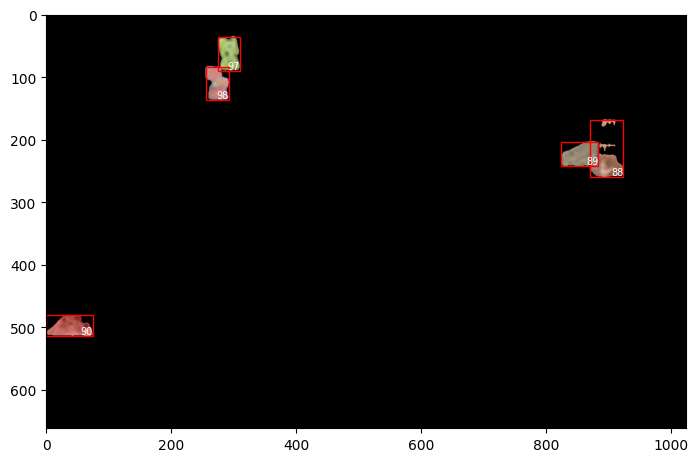

In [247]:
show_def_masks(used_img, sorted_masks,maskIDs=[88, 89, 90, 97, 98])

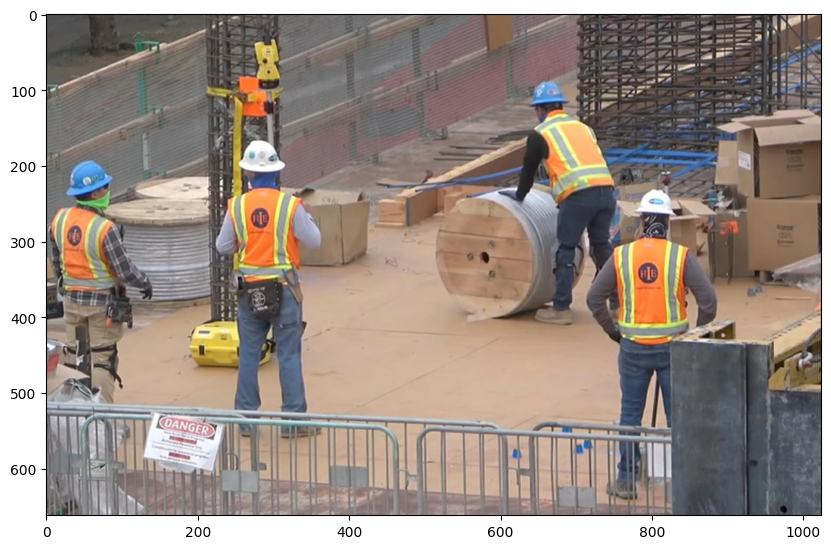

In [232]:
simple_show(used_img, size=(10,8))

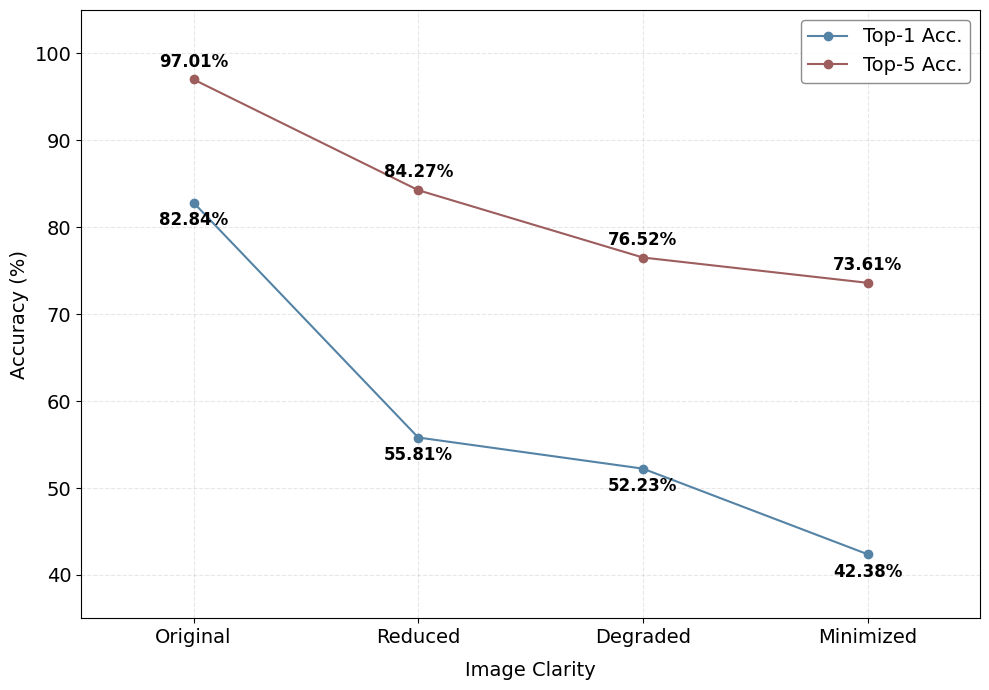

In [293]:
top1 = [82.84, 55.81, 52.23, 42.38]
top5 = [97.01, 84.27, 76.52, 73.61]
title = ["Original", "Reduced", "Degraded", "Minimized"]

plt.figure(figsize=(10,7))
plt.plot(title, top1, color="#5483a5", label="Top-1 Acc.", marker="o")
plt.plot(title, top5, color="#9d5d5d", label="Top-5 Acc.", marker="o")

# 添加数据标签
for i, (y1, y2) in enumerate(zip(top1, top5)):
    plt.text(i, y1-1, f"{y1:.2f}%", ha='center', va='top', fontweight='bold', fontsize=12)
    plt.text(i, y2+1, f"{y2:.2f}%", ha='center', va='bottom', fontweight='bold', fontsize=12)

# 调整X轴标签位置
plt.xticks(range(len(title)), title, fontsize=14)
plt.xlim(-0.5, len(title)-0.5)  # 缩小X轴范围，使标签更靠中间

plt.yticks(fontsize=14)
plt.ylim(35,105)

plt.legend(fontsize=14, frameon=True, framealpha=0.9, edgecolor='gray')
plt.xlabel("Image Clarity", fontsize=14, labelpad=10)
plt.ylabel("Accuracy (%)", fontsize=14)

plt.grid(alpha=0.3,linestyle='--')

plt.tight_layout()

plt.savefig("./clarity.svg", format="svg")
plt.show()